<a href="https://colab.research.google.com/github/ryunino/competition-code/blob/master/signate_JLeagueAttendancePredictor_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://signate.jp/competitions/27

##Import

In [ ]:
!pip install pythermalcomfort

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from scipy import stats
from datetime import datetime
import pytz

from pythermalcomfort.models import pmv
from pythermalcomfort.utilities import v_relative

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

from matplotlib import font_manager
font_manager.fontManager.addfont("./dsws/fonts/ipaexg.ttf")
plt.rc('font', family="IPAexGothic")

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


##Reading

In [ ]:
df_train_base = pd.read_csv("./dsws/motodata/j-league/train.csv", sep=",", header=0, quotechar="\"")
df_train_add = pd.read_csv("./dsws/motodata/j-league/train_add.csv", sep=",", header=0, quotechar="\"")

df_test = pd.read_csv("./dsws/motodata/j-league/test.csv", sep=",", header=0, quotechar="\"")

df_condition_base = pd.read_csv("./dsws/motodata/j-league/condition.csv", sep=",", header=0, quotechar="\"")
df_codition_add =  pd.read_csv("./dsws/motodata/j-league/condition_add.csv", sep=",", header=0, quotechar="\"")

df_stadium = pd.read_csv("./dsws/motodata/j-league/stadium.csv", sep=",", header=0, quotechar="\"")

#追加データの結合
df_train = pd.concat([df_train_base, df_train_add])
df_codition = pd.concat([df_condition_base, df_codition_add])

# train, testとconditionを結合する
df_train_all = pd.merge(df_train, df_codition, how="inner", on="id")
df_test_all = pd.merge(df_test, df_codition, how="inner", on="id")

# 結合したものに、stadiumを結合して上書きする
train_new = pd.merge(df_train_all, df_stadium, how="inner", left_on="stadium", right_on="name")
test_new = pd.merge(df_test_all, df_stadium, how="inner", left_on="stadium", right_on="name")

display(train_new.head(2))
display(test_new.head(2))

"""for i in df_train_all.columns:
  print(f'{i}' ,df_train_all[f'{i}'].unique())"""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_05,away_06,away_07,away_08,away_09,away_10,away_11,name,address,capa
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
1,14012,11831,2012,Ｊ１,第３節第１日,03/24(土),13:03,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,...,下平 匠,青木 拓矢,上田 康太,渡邉 大剛,曺 永哲,東 慶悟,ラファエル,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694


,id,year,stage,match,gameday,time,home,away,stadium,tv,...,away_05,away_06,away_07,away_08,away_09,away_10,away_11,name,address,capa
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,...,高橋 祥平,橋本 晃司,和田 拓也,家長 昭博,富山 貴光,ムルジャ,ズラタン,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
1,15840,2014,Ｊ１,第２０節第１日,08/16(土),19:04,ベガルタ仙台,清水エスパルス,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,...,イ キジェ,本田 拓也,六平 光成,大前 元紀,河井 陽介,高木 俊幸,ノヴァコヴィッチ,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694


"for i in df_train_all.columns:\n  print(f'{i}' ,df_train_all[f'{i}'].unique())"

In [ ]:
train_new.columns
train_new["temperature"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        3.8
1        8.9
2        6.1
3       10.4
4       16.9
        ... 
1948    25.9
1949    31.0
1950    24.2
1951    24.0
1952    20.4
Name: temperature, Length: 1953, dtype: float64

##Pre-processing

In [ ]:
train_new['home'] = train_new['home'].replace('ザスパ草津', 'ザスパクサツ群馬')
test_new['home'] = test_new['home'].replace('ザスパ草津', 'ザスパクサツ群馬')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

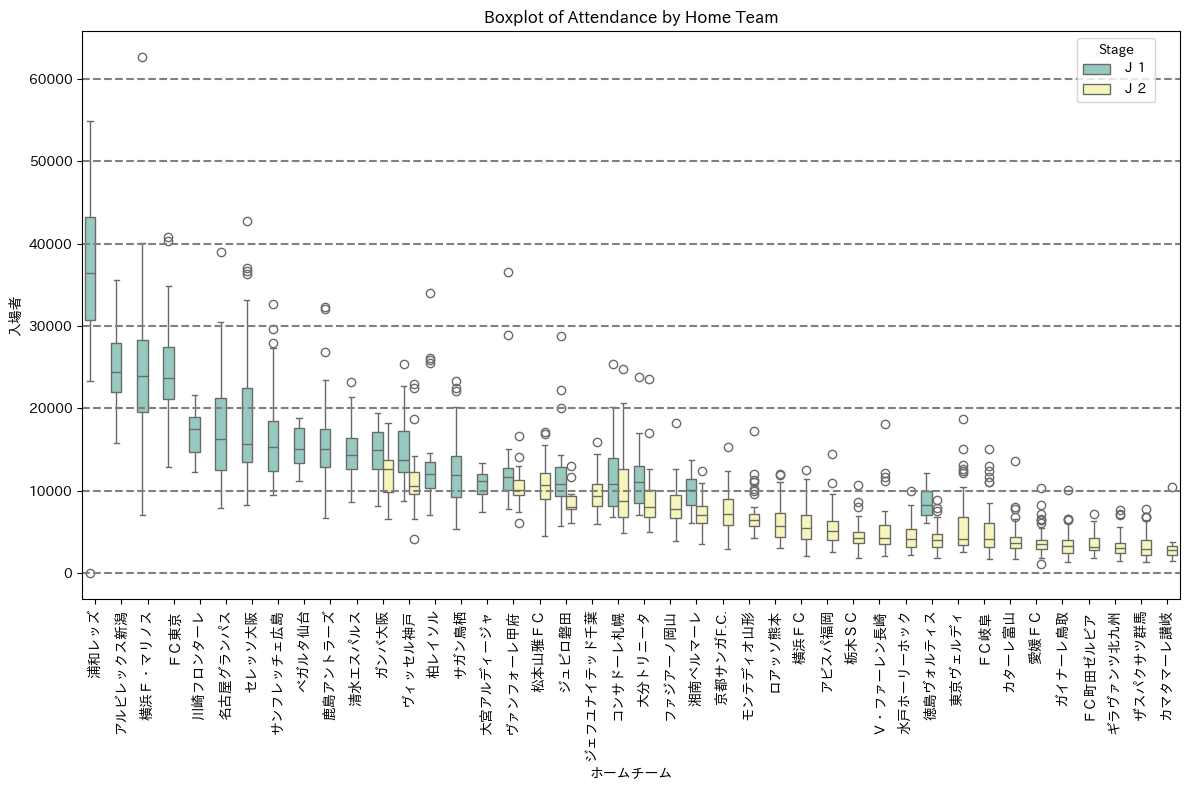

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# ホームチームごとの入場者数の中央値を計算
median_attendance_by_home = train_new.groupby('home')['y'].median().reset_index(name='median_attendance')

# 中央値でソート
median_attendance_by_home_sorted = median_attendance_by_home.sort_values('median_attendance', ascending=False)

# ソートされた順序でホームチームのリストを取得
sorted_home_teams = median_attendance_by_home_sorted['home']

# 元のDataFrameにソートされたカテゴリを適用
train_new['home_sorted'] = pd.Categorical(train_new['home'], categories=sorted_home_teams, ordered=True)

# 箱ひげ図を描画
plt.figure(figsize=(12, 8))
#sns.boxplot(x='home_sorted', y='y', data=train_new)
sns.boxplot(x='home_sorted', y='y', hue='stage', data = train_new, palette='Set3')
plt.xticks(rotation=90)
plt.xlabel('ホームチーム')
plt.ylabel('入場者')

# 1万人ごとに横線を引く
attendance_max = train_new['y'].max()
for line in range(0, attendance_max, 10000):
    plt.axhline(y=line, color='gray', linestyle='--')

"""# 中央値のテキストを追加し、90°反時計回りに回転
for i, team in enumerate(sorted_home_teams):
    median_val = median_attendance_by_home_sorted[median_attendance_by_home_sorted['home'] == team]['median_attendance'].values[0]
    plt.text(i, median_val, f'{median_val}', horizontalalignment='center', verticalalignment='center',
             rotation=90, size='small', color='black', weight='semibold')"""

plt.title('Boxplot of Attendance by Home Team')
plt.tight_layout()
plt.legend(title='Stage', bbox_to_anchor=(0.9, 1), loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

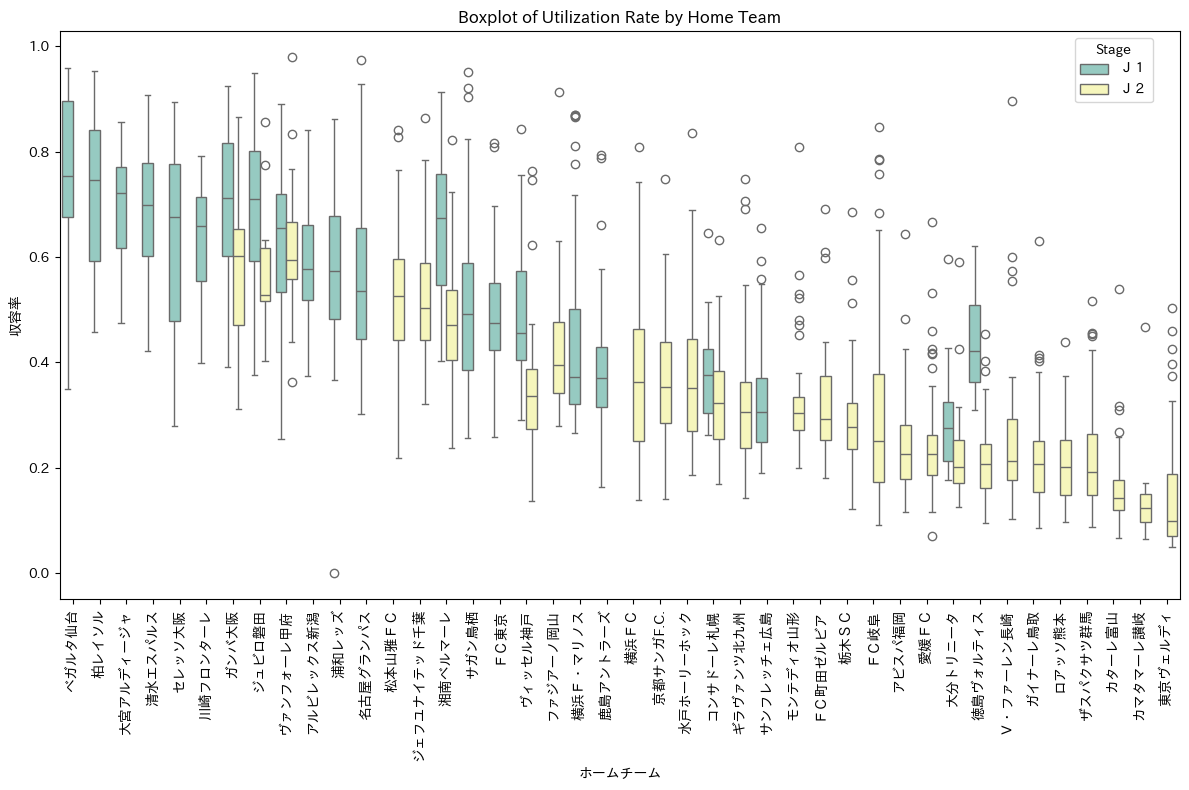

In [ ]:
train_new['utilization_rate'] = train_new['y'] / train_new['capa']

# ホームチームごとの入場者数の中央値を計算
median_attendance_by_home_mid = train_new.groupby('home')['utilization_rate'].median().reset_index(name='median_attendance')

# 中央値でソート
median_attendance_by_home_mid_sorted = median_attendance_by_home_mid.sort_values('median_attendance', ascending=False)

# ソートされた順序でホームチームのリストを取得
sorted_home_teams = median_attendance_by_home_mid_sorted['home']

# 元のDataFrameにソートされたカテゴリを適用
train_new['home_sorted'] = pd.Categorical(train_new['home'], categories=sorted_home_teams, ordered=True)

# 箱ひげ図を描画
plt.figure(figsize=(12, 8))
#sns.boxplot(x='home_sorted', y='y', data=train_new)
sns.boxplot(x='home_sorted', y='utilization_rate', hue='stage', data = train_new, palette='Set3')
plt.xticks(rotation=90)
plt.xlabel('ホームチーム')
plt.ylabel('収容率')

plt.title('Boxplot of Utilization Rate by Home Team')
plt.tight_layout()
plt.legend(title='Stage', bbox_to_anchor=(0.9, 1), loc='upper left')
plt.show()

In [ ]:
train_new = train_new[train_new['id'] != 15699].copy()

# 分析に使える指標のみを取り出す
list_select = ['id', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away', 'tv', 'home_score', 'away_score', 'weather', 'temperature', 'humidity', 'capa', 'stadium']
train_new = train_new[['y'] + list_select]
test_new = test_new[list_select]

train_new['utilization_rate'] = train_new['y'] / train_new['capa']
average_utilization_by_team = train_new.groupby('home')['utilization_rate'].mean().reset_index(name='average_utilization')

#平均収容率
train_new = pd.merge(train_new, average_utilization_by_team, on='home', how='left')
test_new = pd.merge(test_new, average_utilization_by_team, on='home', how='left')

#ステージ
train_new['stage_int'] = train_new['stage'].map({'Ｊ１': 1, 'Ｊ２': 2})
test_new['stage_int'] = test_new['stage'].map({'Ｊ１': 1, 'Ｊ２': 2})

#湿度
train_new['humidity_int'] = train_new['humidity'].str.replace('%', '').astype(int)
test_new['humidity_int'] = test_new['humidity'].str.replace('%', '').astype(int)

#天気
train_new['rain'] = train_new['weather'].apply(lambda x: 1 if '雨' in x or '雪' in x else 0)
train_new['cloudy'] = train_new['weather'].apply(lambda x: 1 if '曇' in x else 0)
train_new['sunny'] = train_new['weather'].apply(lambda x: 1 if '晴' in x else 0)
test_new['rain'] = test_new['weather'].apply(lambda x: 1 if '雨' in x or '雪' in x else 0)
test_new['cloudy'] = test_new['weather'].apply(lambda x: 1 if '曇' in x else 0)
test_new['sunny'] = test_new['weather'].apply(lambda x: 1 if '晴' in x else 0)

#祝休日
train_new['holiday'] = train_new['gameday'].str.contains('祝|土|日').astype(int)
test_new['holiday'] = test_new['gameday'].str.contains('祝|土|日').astype(int)

#曜日
weekdays = {'月': 0, '火': 1, '水': 2, '木': 3, '金': 4, '土': 5, '日': 6}
train_new['week'] = train_new['gameday'].str.extract('(\w)').replace(weekdays).astype(int)
test_new['week'] = test_new['gameday'].str.extract('(\w)').replace(weekdays).astype(int)

#節
train_new['sec'] = train_new['match'].str.extract('第(\d+)節').astype(int)
test_new['sec'] = test_new['match'].str.extract('第(\d+)節').astype(int)

#日付
train_new['date'] = pd.to_datetime(train_new['year'].astype(str) + '/' + train_new['gameday'].str.extract('(\d+/\d+)')[0], format='%Y/%m/%d')
test_new['date'] = pd.to_datetime(test_new['year'].astype(str) + '/' + test_new['gameday'].str.extract('(\d+/\d+)')[0], format='%Y/%m/%d')

#年の内いつごろか
train_new['date366'] = train_new['date'].dt.dayofyear
test_new['date366'] = test_new['date'].dt.dayofyear

train_new['time'] = train_new['time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)
test_new['time'] = test_new['time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)

display(train_new.head(2))
display(test_new.head(2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:37: DeprecationWarning: invalid escape sequence '\w'
<>:38: DeprecationWarning: invalid escape sequence '\w'
<>:41: DeprecationWarning: invalid escape sequence '\d'
<>:42: DeprecationWarning: invalid escape sequence '\d'
<>:45: DeprecationWarning: invalid escape sequence '\d'
<>:46: DeprecationWarning: invalid escape sequence '\d'
<>:37: DeprecationWarning: invalid escape sequence '\w'
<>:38: DeprecationWarning: invalid escape sequence '\w'
<>:41: DeprecationWarning: invalid escape sequence '\d'
<>:42: DeprecationWarning: invalid escape sequence '\d'
<>:45: DeprecationWarning: invalid escape sequence '\d'
<>:46: DeprecationWarning: in

,y,id,year,stage,match,gameday,time,home,away,tv,...,stage_int,humidity_int,rain,cloudy,sunny,holiday,week,sec,date,date366
0,18250,13994,2012,Ｊ１,第１節第１日,03/10(土),14.066667,ベガルタ仙台,鹿島アントラーズ,スカパー／ｅ２／スカパー光／ＮＨＫ総合,...,1,66,1,0,0,1,0,1,2012-03-10,70
1,11831,14012,2012,Ｊ１,第３節第１日,03/24(土),13.050000,ベガルタ仙台,大宮アルディージャ,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）,...,1,57,1,1,0,1,0,3,2012-03-24,84


,id,year,stage,match,gameday,time,home,away,tv,home_score,...,stage_int,humidity_int,rain,cloudy,sunny,holiday,week,sec,date,date366
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19.066667,ベガルタ仙台,大宮アルディージャ,スカパー！／スカパー！プレミアムサービス,2,...,1,70,0,0,1,1,0,18,2014-08-02,214
1,15840,2014,Ｊ１,第２０節第１日,08/16(土),19.066667,ベガルタ仙台,清水エスパルス,スカパー！／スカパー！プレミアムサービス,3,...,1,83,0,1,0,1,0,20,2014-08-16,228


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


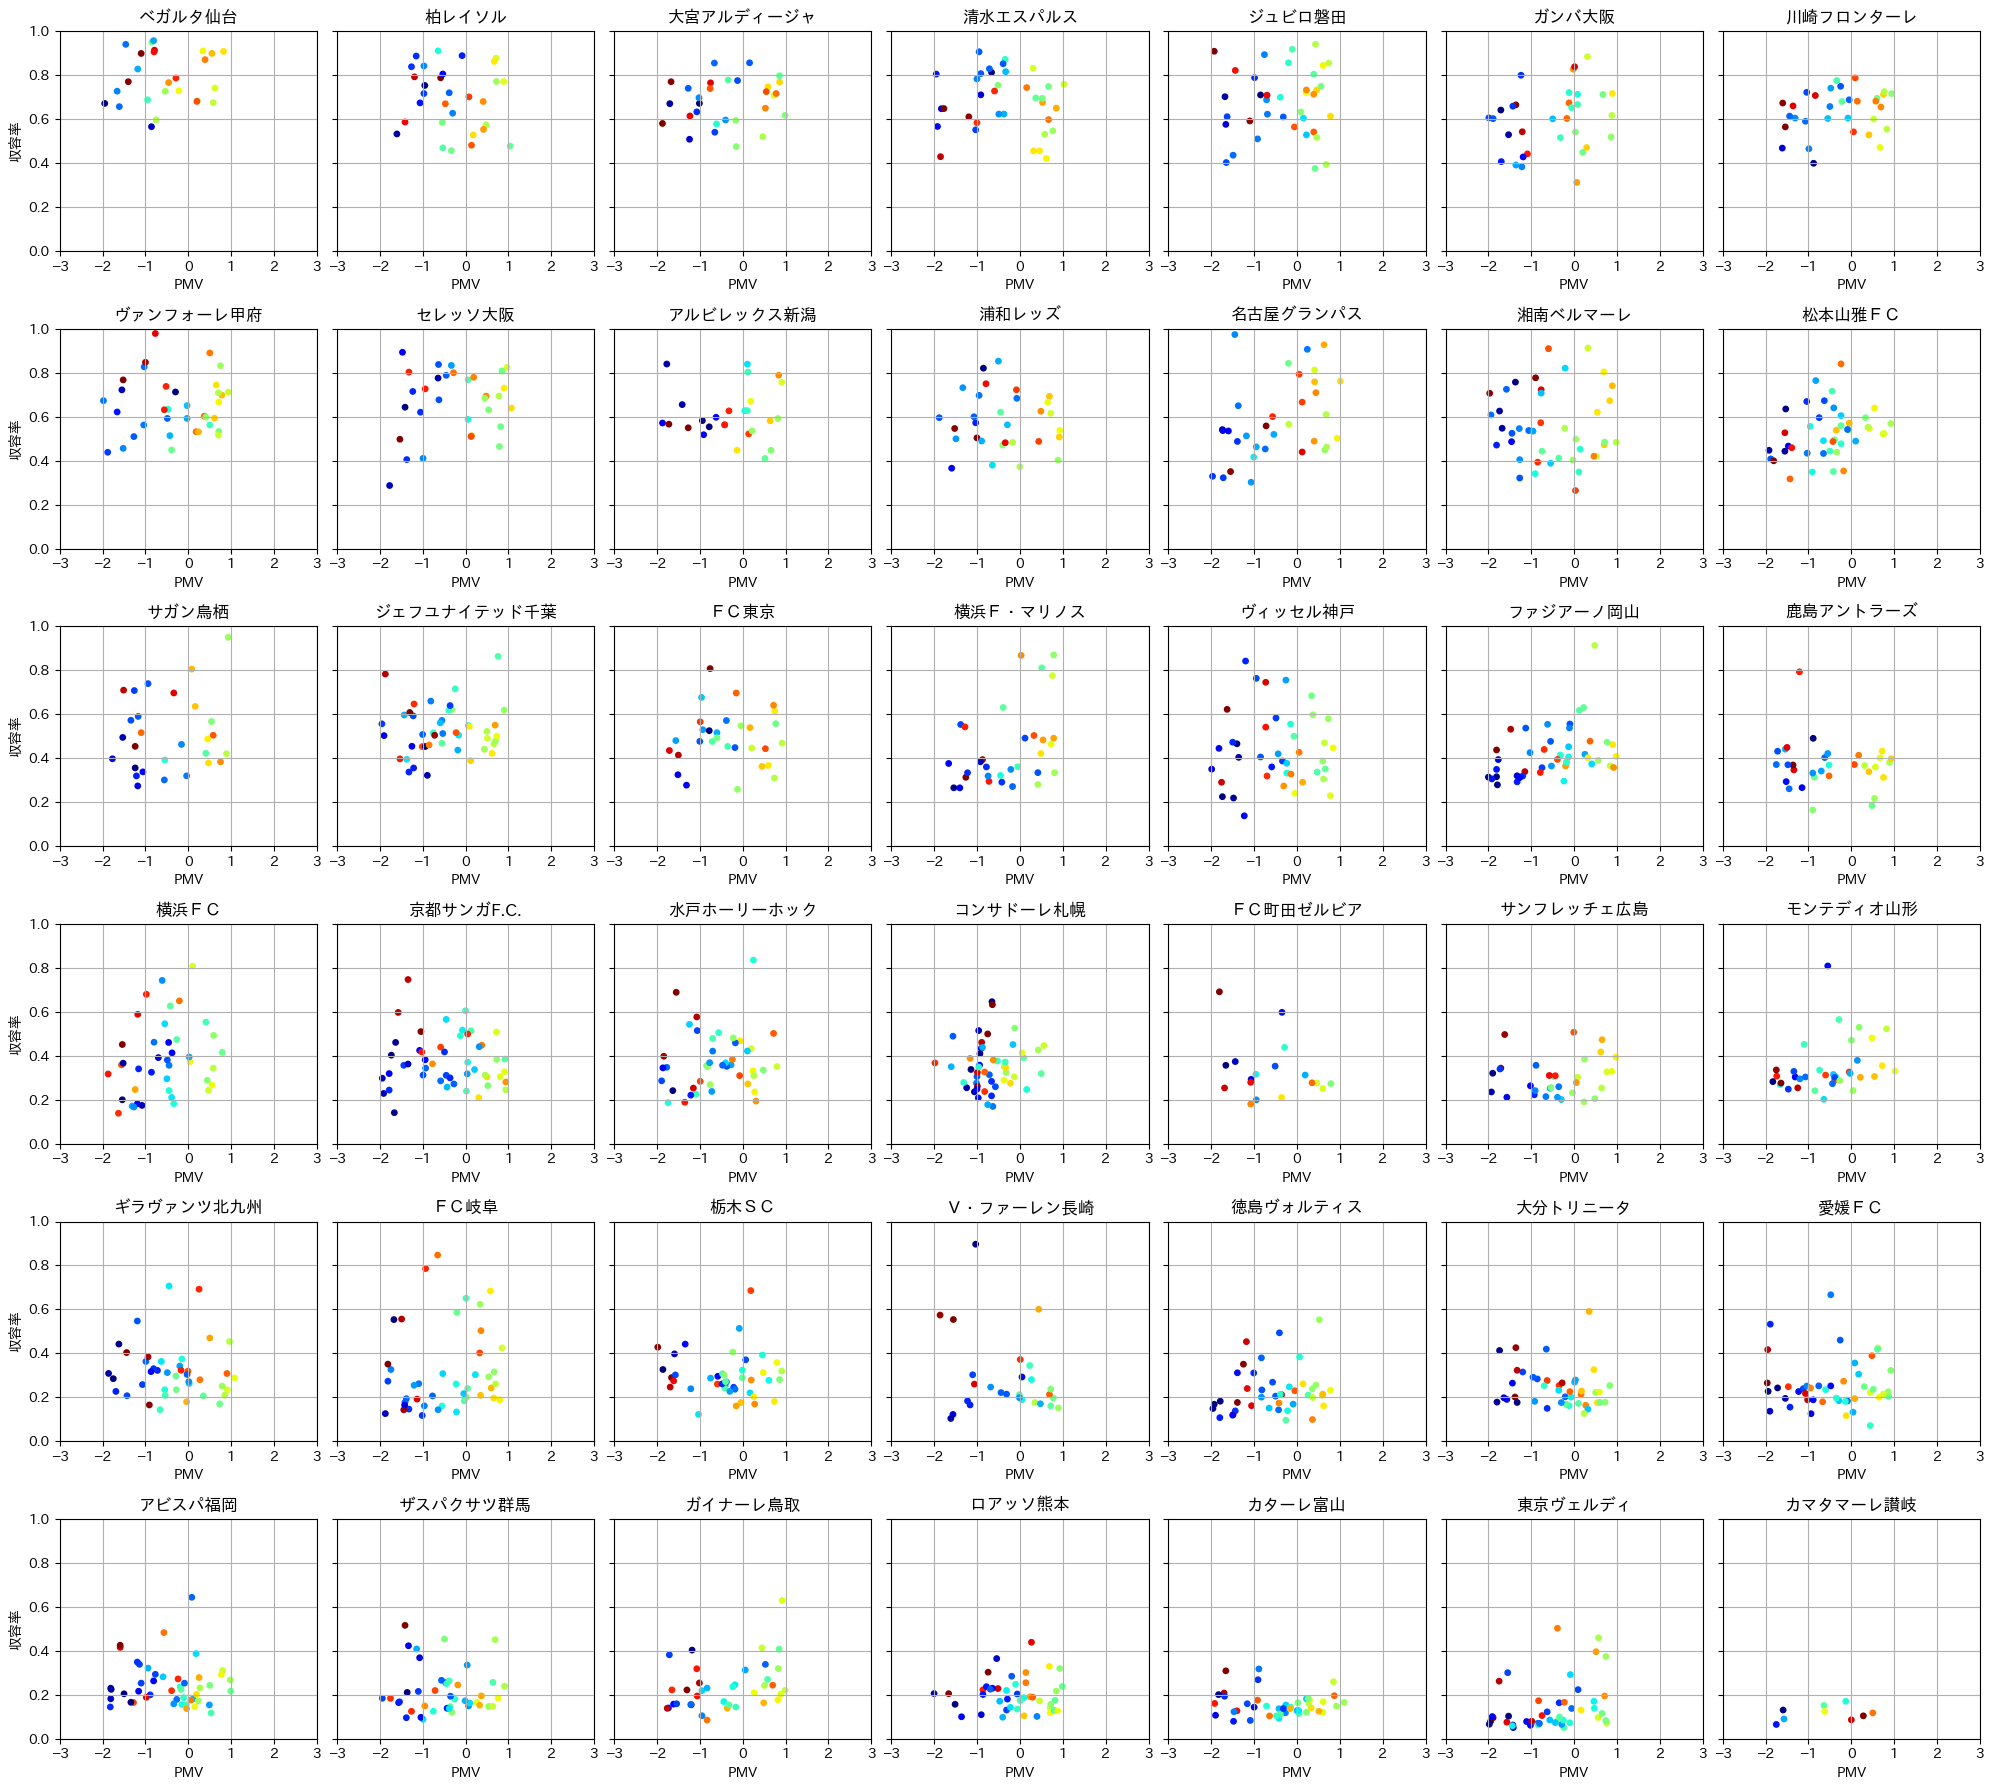

In [ ]:
# https://pythermalcomfort.readthedocs.io/en/latest/reference/pythermalcomfort.html#adaptive-predicted-mean-vote-apmv

list_PMV = []
for i in range(len(train_new)):
  list_PMV.append(pmv(tdb = train_new["temperature"][i],
                       tr = 25,
                       vr = v_relative(v=0.1, met=1.2),
                       rh = train_new["humidity_int"][i],
                       met = 1.2,
                       clo = 0.5
                       )
  )

train_new["PMV"] = list_PMV

sorted_df = average_utilization_by_team.sort_values(by='average_utilization', ascending=False).reset_index(drop=True)
teams = sorted_df['home']

# rowsとcolsの計算を再実行し、グラフを再生成
num_teams = len(teams)
cols = 7  # 最大列数
rows = (num_teams + cols - 1) // cols  # 必要な行数を計算

# 修正：チーム数が4以下の場合に1次元配列となる問題に対処
fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 3), sharey=True, squeeze=False)  # squeeze=Falseを追加して常に2D配列を保持
colorbar_ax = None  # カラーバー用の軸を初期化

for i, team in enumerate(teams):
    ax = axs[i // cols, i % cols]
    subset = train_new[train_new['home'] == team]
    scatter = ax.scatter(subset['PMV'], subset['utilization_rate'], c=subset['date366'], cmap='jet', s=15)
    ax.set_title(team)
    ax.set_xlabel('PMV')
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 1)
    if i % cols == 0:
        ax.set_ylabel('収容率')
    ax.grid(True)
    colorbar_ax = scatter  # 最後のscatterプロットを記録

# 不要なサブプロットを非表示
for j in range(i + 1, rows * cols):
    axs[j // cols, j % cols].axis('off')

#fig.colorbar(colorbar_ax, ax=axs.ravel().tolist(), location='right', label='Day of Year')

plt.tight_layout()
plt.show()


##回帰モデルの作成

In [ ]:
train_new['PMV'] = train_new['PMV'].replace([np.inf, -np.inf], np.nan, inplace=True)
train_new['PMV'] = train_new['PMV'].fillna(0.1)
train_new['PMV'] = train_new['PMV'].abs()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#回帰モデルの作成
list_x = ['capa', 'stage_int', 'average_utilization', 'humidity_int', 'rain', 'cloudy', 'sunny', 'holiday', 'week', 'temperature', 'date366', 'time', 'PMV']

"""
残り['id', 'home', 'away', 'tv', 'home_score', 'away_score', 'sec', 'day', 'year']"""

list_tmp = list_x + ['home']
x_dummies = pd.get_dummies(train_new[list_tmp], drop_first=True)
x = sm.add_constant(x_dummies)
y = train_new['y']

sm_j = sm.OLS(y,x).fit()
sm_j.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     164.2
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:34:11   Log-Likelihood:                -18673.
No. Observations:                1952   AIC:                         3.745e+04
Df Residuals:                    1899   BIC:                         3.775e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
capa                    0.2933      0.014     21.506      0.000       0.267       0.320
stage_int           -2447.4884    381.857     -6.409      0.000   -3196.392   -1698.585
average_utilization  1.157e+04   3013.564      3.839      0.000    5657.724    1.75e+04
humidity_int          -17.5284      6.488     -2.702      0.007     -30.252      -4.805
rain                 -576.8954    283.613     -2.034      0.042   -1133.122     -20.669
cloudy                383.3590    243.583      1.574      0.116     -94.360     861.078
sunny                 341.9905    280.717      1.218      0.223    -208.556     892.537
holiday              1708.4678    265.292      6.440      0.000    1188.174    2228.761
week                 -170.7482    484.895     -0.352      0.725   -1121.730     780.234
temperature             5.7278     19.544      0.293      0.769     -32.602      44.058
date366                 9.8899      2.410      4.103      0.000       5.163      14.617
time                  -74.5781     47.207     -1.580      0.114    -167.161      18.005
PMV                 -3178.5557   5444.382     -0.584      0.559   -1.39e+04    7499.042
home_アルビレックス新潟       7311.6890   1555.165      4.702      0.000    4261.678    1.04e+04
home_カターレ富山         -1038.2575    673.219     -1.542      0.123   -2358.585     282.070
home_カマタマーレ讃岐        -792.6273   1159.876     -0.683      0.494   -3067.393    1482.138
home_ガイナーレ鳥取          336.7634    717.365      0.469      0.639   -1070.144    1743.671
home_ガンバ大阪           2624.2103   1579.379      1.662      0.097    -473.291    5721.711
home_ギラヴァンツ北九州        618.1122    790.151      0.782      0.434    -931.542    2167.767
home_コンサドーレ札幌         423.9270    891.935      0.475      0.635   -1325.348    2173.202
home_サガン鳥栖            898.0917   1384.243      0.649      0.517   -1816.705    3612.888
home_サンフレッチェ広島       -359.3559    988.326     -0.364      0.716   -2297.674    1578.962
home_ザスパクサツ群馬         141.6327    676.625      0.209      0.834   -1185.374    1468.639
home_ジェフユナイテッド千葉     2146.1393   1144.484      1.875      0.061     -98.438    4390.717
home_ジュビロ磐田           413.9361   1715.780      0.241      0.809   -2951.075    3778.947
home_セレッソ大阪          3701.0659   1622.082      2.282      0.023     519.817    6882.315
home_ファジアーノ岡山        1713.0632    939.168      1.824      0.068    -128.846    3554.973
home_ベガルタ仙台          2012.8293   2079.773      0.968      0.333   -2066.051    6091.709
home_モンテディオ山形         787.5497    768.531      1.025      0.306    -719.704    2294.804
home_ロアッソ熊本         -1154.9677    677.874     -1.704      0.089   -2484.424     174.488
home_ヴァンフォーレ甲府       1207.6467   1575.597      0.766      0.443   -1882.436    4297.730
home_ヴィッセル神戸         1664.8987   1068.815      1.558      0.119    -431.276    3761.073
hom

##予測値のRMSEの計算

In [ ]:
train_new['pred_y'] = sm_j.predict(x)
pred_y = train_new['pred_y']

def calc_rmse(x,y):
  return math.sqrt(np.mean((x-y)**2))
rmse_train = calc_rmse(pred_y, y)

print(f"Predict RMSE：{rmse_train}")

Predict RMSE：3454.312691029079


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


##結果の分析

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,y,pred_y,y-pred_y,abs(y-pred_y),stage,match,home,away,stadium,capa
419,15127,62632,29949.886708,32682.113292,32682.113292,Ｊ１,第３３節第１日,横浜Ｆ・マリノス,アルビレックス新潟,日産スタジアム,72327
59,15765,38966,19517.463547,19448.536453,19448.536453,Ｊ１,第１１節第１日,名古屋グランパス,セレッソ大阪,豊田スタジアム,40000
475,15725,42723,23890.818884,18832.181116,18832.181116,Ｊ１,第７節第２日,セレッソ大阪,ガンバ大阪,ヤンマースタジアム長居,47816
663,15736,40761,24265.617284,16495.382716,16495.382716,Ｊ１,第８節第１日,ＦＣ東京,セレッソ大阪,味の素スタジアム,49970
381,15787,54350,37927.130038,16422.869962,16422.869962,Ｊ１,第１４節第１日,浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,63700


,id,y,pred_y,y-pred_y,abs(y-pred_y),stage,match,home,away,stadium,capa
361,14880,23295,34974.588436,-11679.588436,11679.588436,Ｊ１,第５節第１日,浦和レッズ,ジュビロ磐田,埼玉スタジアム２００２,63700
364,14916,24184,35113.421091,-10929.421091,10929.421091,Ｊ１,第９節第２日,浦和レッズ,ベガルタ仙台,埼玉スタジアム２００２,63700
367,14982,23725,34462.558413,-10737.558413,10737.558413,Ｊ１,第１７節第１日,浦和レッズ,横浜Ｆ・マリノス,埼玉スタジアム２００２,63700
662,15720,14165,24723.636143,-10558.636143,10558.636143,Ｊ１,第６節第１日,ＦＣ東京,サガン鳥栖,味の素スタジアム,49970
377,15722,26762,36952.512637,-10190.512637,10190.512637,Ｊ１,第６節第１日,浦和レッズ,ベガルタ仙台,埼玉スタジアム２００２,63700


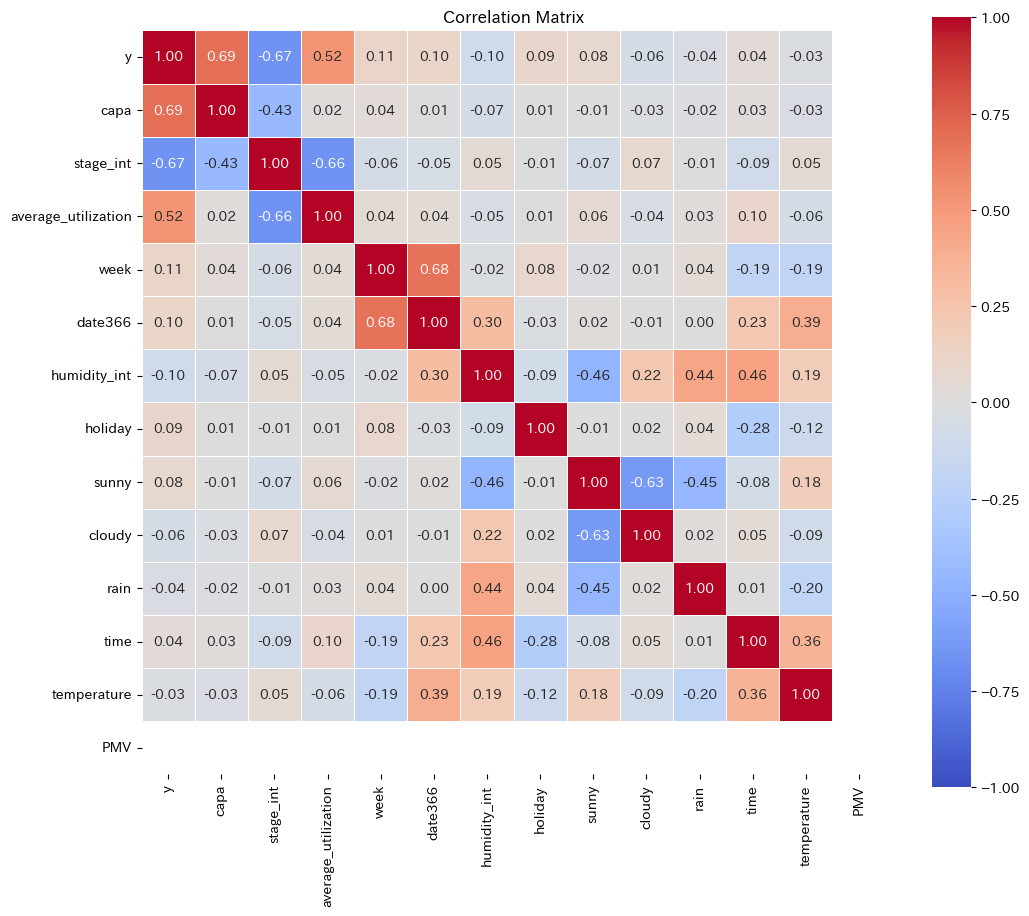

In [ ]:
df_train_analysis = train_new.copy()
df_train_analysis['pred_y'] = train_new['pred_y']
df_train_analysis['y-pred_y'] = train_new['y'] - train_new['pred_y']
df_train_analysis['abs(y-pred_y)'] = df_train_analysis['y-pred_y'].abs()
df_train_analysis = df_train_analysis[['id', 'y', 'pred_y', 'y-pred_y', 'abs(y-pred_y)', 'stage', 'match', 'home', 'away', 'stadium', 'capa']]
display(df_train_analysis[df_train_analysis['y-pred_y'] > 0].sort_values('abs(y-pred_y)', ascending = False).head(5))
display(df_train_analysis[df_train_analysis['y-pred_y'] <= 0].sort_values('abs(y-pred_y)', ascending = False).head(5))

list_x_with_y = list_x.copy()
list_x_with_y.append('y')
corr_matrix = train_new[list_x_with_y].corr()

corr_y_abs = corr_matrix.loc['y'].abs().sort_values(ascending=False)
sorted_columns = corr_y_abs.index.tolist()

sorted_corr_matrix = corr_matrix.reindex(index=sorted_columns, columns=sorted_columns)

plt.figure(figsize=(12, 10))
sns.heatmap(sorted_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#提出用データの作成

In [ ]:
x2 = pd.get_dummies(test_new[list_tmp], drop_first=True)
x2['home_ガイナーレ鳥取'] =0
x2['home_Ｖ・ファーレン長崎'] = 0
x2['home_ＦＣ町田ゼルビア' ] = 0
x2 = sm.add_constant(x2)
pred = sm_j.predict(x2)
submit = test_new[['id']].copy()
submit['pred'] = pred
japan_timezone = pytz.timezone('Asia/Tokyo')
submit.to_csv(f"./dsws/submit/submit_linear_{datetime.now(japan_timezone).strftime('%Y%m%d-%H%M')}.csv", sep=",", index=False, header=False)
submit.head()